# Анализ сервиса аренды самокатов GoFast

В данном проекте мне - аналитику популярного сервиса аренды самокатов GoFast - передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;

с подпиской Ultra
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

In [1]:
# Сначала импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

#### Шаг 1. Загрузка данных

In [2]:
#Загружаем исходные таблицы и выводим основную информацию о них
users_go = pd.read_csv('/datasets/users_go.csv')
riders_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

display(users_go.head())
display(riders_go.head())
display(subscriptions_go.head())

display(users_go.info())
display(riders_go.info())
display(subscriptions_go.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

На данном этапе обнаружено, что необходимо поменять формат даты. Пропусков не обнаружено, дубликаты на первый взгляд не выявлены. 

#### Шаг 2. Предобработка данных

In [3]:
#Изменяем формат даты, из данных с датой создаем новый столбец с номером месяца
riders_go['date'] = pd.to_datetime(riders_go['date'])
print(riders_go.info())

riders_go['month'] = riders_go['date'].dt.month
display(riders_go.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
None


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Формат даты изменен, новый столбец добавлен.

In [4]:
#Проверяем количество дубликатов
d_users = users_go.duplicated().sum()
print('количество дубликатов до удаления:', d_users)

количество дубликатов до удаления: 31


In [5]:
users_go = users_go.drop_duplicates().reset_index(drop = True)
print('дубликаты после удаления:', users_go.duplicated().sum())

дубликаты после удаления: 0


In [6]:
d_riders = riders_go.duplicated().sum()
print(d_riders)

0


В первой таблице были выявлены и удалены дубликаты, такжы были восстановлены индексы. В других таблицах дубликатов не обнаружено.

#### Шаг 3. Исследовательский анализ данных

Text(0, 0.5, 'частота встречаемости')

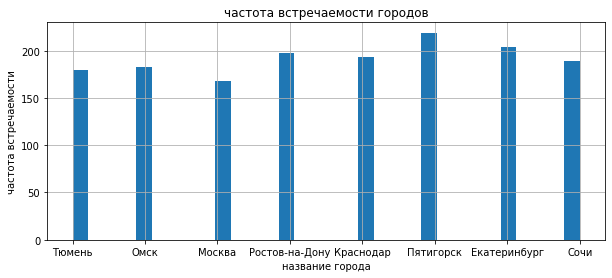

In [7]:
#Визуализируем информацию о частоте встречаемости городов
users_go['city'].hist(bins=32, grid=True, figsize=(10,4))
plt.title("частота встречаемости городов")
plt.xlabel("название города")
plt.ylabel("частота встречаемости")

На графике видно, что чаще всего арендовали самокаты в Пятигорске

Число пользователей без подписки: 835
Число пользователей с подпиской: 699


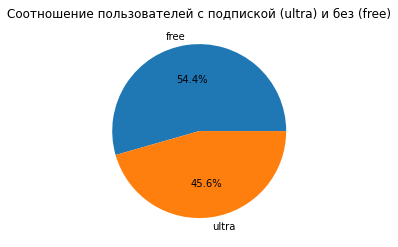

In [8]:
#Посмотрим соотношение пользователей с подпиской (ultra) и без (free)
u_count = (users_go['subscription_type'] == 'ultra').sum()
f_count = (users_go['subscription_type'] == 'free').sum()
print('Число пользователей без подписки:', f_count)
print('Число пользователей с подпиской:', u_count)

vals = [835, 699]
labels = ["free", "ultra"]
plt.pie(vals, labels=labels, autopct='%1.1f%%')
plt.title("Соотношение пользователей с подпиской (ultra) и без (free)")
plt.show()

Чаще всего люди не пользуются подпиской, но разница в количестве не велика.

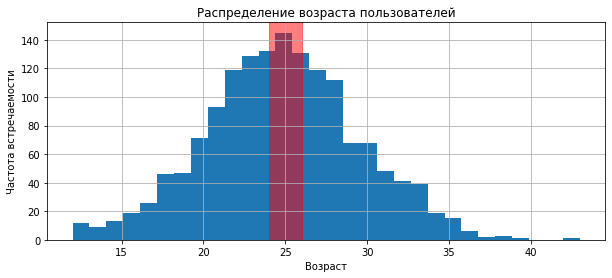

In [9]:
#Посмотрим на возраст пользователей
users_go['age'].hist(bins=30, grid=True, figsize=(10,4))
plt.axvspan(24, 26, color='red', alpha=0.5)
plt.title("Распределение возраста пользователей")
plt.xlabel("Возраст")
plt.ylabel("Частота встречаемости")
plt.show()

Самыми частыми клиентами являются люди в возрасте 25 лет

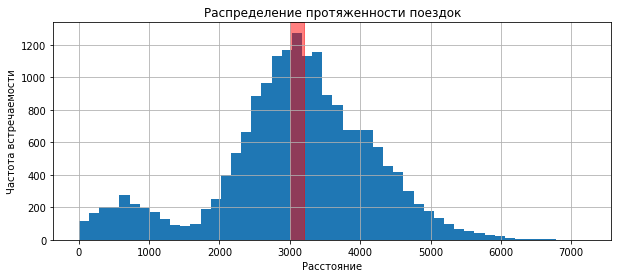

In [10]:
#Визуализируем расстояние, которое проехали пользователи за одну поездку
riders_go['distance'].hist(bins=50, grid=True, figsize=(10,4))
plt.axvspan(3000, 3200, color='red', alpha=0.5)
plt.title("Распределение протяженности поездок")
plt.xlabel("Расстояние")
plt.ylabel("Частота встречаемости")
plt.show()

На полученном графике видно два пика. По поводу первого пика можно предположить, что люди часто арендовали самокат для того, чтобы доехать до какого-то близкого объекта, либо самокат разряжался или попадал в зону, где движение самоката заблокировано. Самыми частыми оказались поездки протяженностью примерно 3.1 км


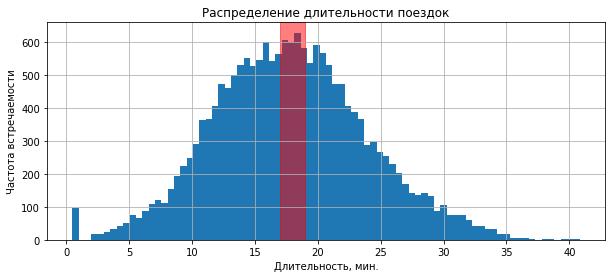

In [11]:
#Посмотрим на распределение длительности поездок
riders_go['duration'].hist(bins=80, grid=True, figsize=(10,4))
plt.axvspan(17, 19, color='red', alpha=0.5)
plt.title("Распределение длительности поездок")
plt.xlabel("Длительность, мин.")
plt.ylabel("Частота встречаемости")
plt.show()

На данном графике, как и на графике с длительностью, виден пик с небольшими значениями. Он может быть обоснован теми же причинами. В основном поездка длится 17-19 минут.

#### Шаг 4. Объединение данных

In [12]:
#Объединяем данные из всех таблиц в одну, проверим количество строк до и после объединения
data1 = users_go.merge(riders_go)
data = data1.merge(subscriptions_go)
data['duration'] = np.ceil(data['duration']) 
display(data)
print(riders_go.count())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


user_id     18068
distance    18068
duration    18068
date        18068
month       18068
dtype: int64


Количество строк до и после объединения проверяли по второй таблице, т.к. она включает в себя максимально широкий спектр информации и показывает нам, сколько строк должно быть. Количество строк совпало, значит данные соединились правильно.

Создадим раздельные таблицы с данными о пользователях с подпиской и без:

In [13]:
# Пользователи с подпиской
data_ultra = data[data['subscription_type'] == 'ultra']
display(data_ultra)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,25.0,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,16.0,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,15.0,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,16.0,2021-10-17,10,6,0,199


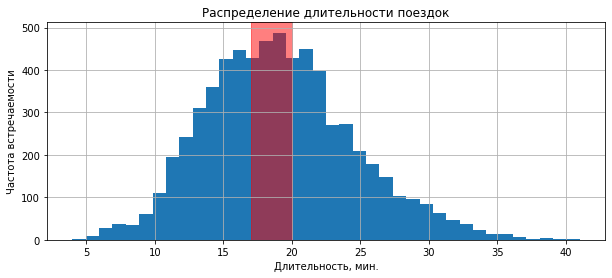

In [14]:
data_ultra['duration'].hist(bins=38, grid=True, figsize=(10,4))
plt.axvspan(17, 20, color='red', alpha=0.5)
plt.title("Распределение длительности поездок")
plt.xlabel("Длительность, мин.")
plt.ylabel("Частота встречаемости")
plt.show()

Среднее время поездки пользователей с подпиской составляет ~ 18 минут

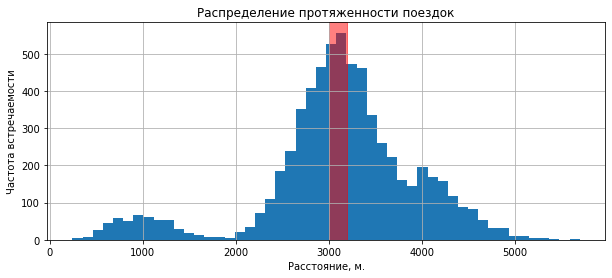

In [15]:
data_ultra['distance'].hist(bins=50, grid=True, figsize=(10,4))
plt.axvspan(3000, 3200, color='red', alpha=0.5)
plt.title("Распределение протяженности поездок")
plt.xlabel("Расстояние, м.")
plt.ylabel("Частота встречаемости")
plt.show()

Пользователи с подпиской чаще всего совершают поездки протяженностью 3-3.2 км.

In [16]:
# Без подписки
data_free = data[data['subscription_type'] == 'free']
display(data_free)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


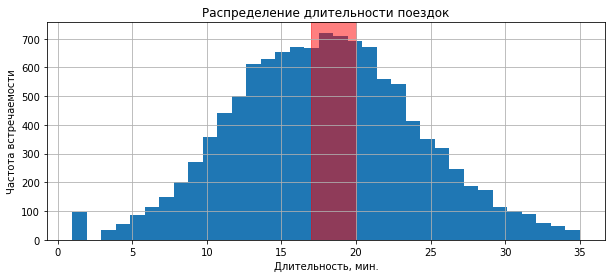

In [17]:
data_free['duration'].hist(bins=35, grid=True, figsize=(10,4))
plt.axvspan(17, 20, color='red', alpha=0.5)
plt.title("Распределение длительности поездок")
plt.xlabel("Длительность, мин.")
plt.ylabel("Частота встречаемости")
plt.show()

Чаще всего пользователи без подписки совершают поездки длительностью 17-19 минут

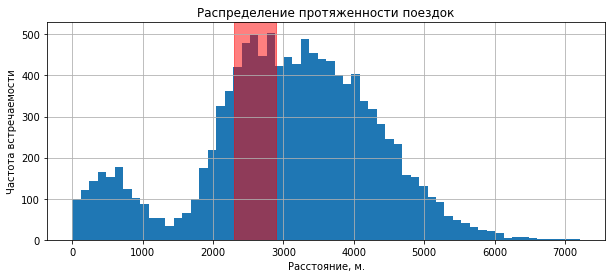

In [18]:
data_free['distance'].hist(bins=60, grid=True, figsize=(10,4))
plt.axvspan(2300, 2900, color='red', alpha=0.5)
plt.title("Распределение протяженности поездок")
plt.xlabel("Расстояние, м.")
plt.ylabel("Частота встречаемости")
plt.show()

Чаще всего расстояние поездки у пользователей без подписки составляет ~ 2.5 км.

Глядя на эти графики видно, что среднее время поездки пользователей обеих категорий примерно равно, а протяженность - разная. Пользователи с подпиской в среднем проезжают большее расстояние за поездку, чем пользователи без неё.

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [19]:
sorted_data = data.pivot_table(index=['user_id', 'month'], values = ['distance', 'duration', 'name', 'subscription_type'], aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type': 'min'})
sorted_data.columns = ['total_distance', 'total_duration', 'trip_count', 'subscription_type']
display(sorted_data)


total_distance  total_duration  trip_count subscription_type
user_id month                                                              
1       1         7027.511294            42.0           2             ultra
        4          754.159807             7.0           1             ultra
        8         6723.470560            46.0           2             ultra
        10        5809.911100            32.0           2             ultra
        11        7003.499363            56.0           3             ultra
...                       ...             ...         ...               ...
1534    6         3409.468534            26.0           2              free
        8         7622.453034            48.0           2              free
        9         4928.173852            23.0           1              free
        11       13350.015305            78.0           4              free
        12        2371.711192            16.0           1              free

[11331 rows x 4 columns]

In [20]:
# Добавим столбец с помесячной выручкой от каждого пользователя
sorted_income = sorted_data.merge(subscriptions_go , on = 'subscription_type')
sorted_income['month'] = riders_go['date'].dt.month
sorted_income['income'] = (sorted_income['start_ride_price'] * sorted_income['trip_count']) + (sorted_income['minute_price'] * sorted_income['total_duration']) + sorted_income['subscription_fee']

display(sorted_income)

,total_distance,total_duration,trip_count,subscription_type,minute_price,start_ride_price,subscription_fee,month,income
0,7027.511294,42.0,2,ultra,6,0,199,1,451.0
1,754.159807,7.0,1,ultra,6,0,199,1,241.0
2,6723.470560,46.0,2,ultra,6,0,199,4,475.0
3,5809.911100,32.0,2,ultra,6,0,199,8,391.0
4,7003.499363,56.0,3,ultra,6,0,199,8,535.0
...,...,...,...,...,...,...,...,...,...
11326,3409.468534,26.0,2,free,8,50,0,11,308.0
11327,7622.453034,48.0,2,free,8,50,0,3,484.0
11328,4928.173852,23.0,1,free,8,50,0,4,234.0
11329,13350.015305,78.0,4,free,8,50,0,5,824.0


#### Шаг 6. Проверка гипотез

Нулевая гипогтеза: пользователи с подпиской и без тратят одинаковое время на поездки.
Альтернативная гипотеза: пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки.

In [21]:
sample_1 = data_ultra['duration']
sample_2 = data_free['duration']
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Среднее время поездки пользователей с подпиской:', data_ultra['duration'].mean())
print('Среднее время поездки пользователей без подписки:', data_free['duration'].mean())

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу
Среднее время поездки пользователей с подпиской: 19.037692307692307
Среднее время поездки пользователей без подписки: 17.890992392807746


Вывод: пользователи с подпиской совершают более длительные поездки.

Нулевая гипотеза: пользователи с подпиской проезжают 3130 метров
Альтернативная гипотеза: пользователи с подпиской проезжают больше 3130 метров

In [22]:
interested_value = 3130
alpha = 0.05
results = st.ttest_1samp(data_ultra['distance'], interested_value, alternative = 'greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Вывод: пользователи с подпиской, скорее всего,  проезжают за одну поездку примерно 3130 метров

Нулевая гипотеза: пользователи с подпиской и без приносят одинаковый доход.   
Альтернативная гипотеза: пользователи с подпиской приносят больший доход, чем пользователи без подписки.

In [23]:
income_ultra = sorted_income[sorted_income['subscription_type'] == 'ultra']
income_free = sorted_income[sorted_income['subscription_type'] == 'free']

sample_1 = income_ultra['income']
sample_2 = income_free['income']
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Средняя выручка от пользователей с подпиской:', income_ultra['income'].mean())
print('Средняя выручка от пользователей без подписки:', income_free['income'].mean())

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу
Средняя выручка от пользователей с подпиской: 362.7921906022502
Средняя выручка от пользователей без подписки: 328.6413651073845


Вывод: доход от с подпиской выше, чем от пользователей без подписки.

Нулевая гипотеза: количество обращений равно   
Альтернативная гипотеза: количество обращений после обновления значительно снизилось

In [26]:
before_update = [...]
after_update = [...]
alpha = 0.05
results = st.ttest_rel(before_update, after_update, alternative = 'less')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем Н0 о равенстве количества обращений')
else:
    print('Не удалось опровергнуть Н0')

TypeError: unsupported operand type(s) for -: 'ellipsis' and 'ellipsis'

#### Шаг 7. Распределения

Вывод: в данной работе я анализировал данные о сервисе аренды самокатов. Сначала я загрузил исходные данные, проверил на пропуски, удалил дубликаты. Зтем визуализировал и исследовал общую информацию о пользователях и поездках. На данном этапе было определено, что: чаще всего сервисом пользовались в Пятигорске; соотношение пользователей с подпиской к пользователям без подписки равняется 54.4% на 45.6% соответственно;средний возраст пользователей - 25 лет; за проездку пользователи в среднем преодолевают 3.1 км; поездка в среднем длится 17-19 минут. Дальше я объединил все исходные данные в одну таблицу, округлил время продолжительности поездок, создал из получившейся таблицы две раздельных по пользователям с подпиской и без. Затем исследовал информацию о длительности и протяженности поездок для обоих типов пользователей и получил следующие результаты: среднее время поездки у них оказалось примерно одинаковым, но протяженность оказалась большей у пользователей с подпиской. Потом я создал таблицу с суммарным расстоянием, количеством поездок и временем для каждого пользователя за каждый месяц. В эту же таблицу добавил столбец с помесячной выручкой от каждого пользователя. Затем я проверял представленные гипотезы и на основе проверки выявил, что: пользователи с подпиской совершают поездки дольшей продолжительности, проезжают за поездку в среднем примерно 3130 метров, и приносят больший доход.